# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

here is a few metrics that could be use

1) Information Theoretic approaches :KL Divergence,Jensen Shanon Divergence

2)Kernel Density Estimation approaches :Mean Maximum Discrepancy (MMD)

3) Earth Mover Distance

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

Divergence based methods like KL and JSD requires density estimation.
MMD is non parametric method and doesn't require any density estimation.
So they both ways have their limits.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

Different choices of dimension of the input noise encode variation. GAN learns a lower-dimensional representation of the high dimensional data input and its mapping from lower-dimensional to real-like data sample,whenever we provide a random noise as input.Given that we intend to map the high dimensional data to a low dimensional distribution, we would like the
dimension of noise to be as small as possible.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

if we recompute the generator gradient with the presence of noise, hen noise is added, the gradient of the objective function equals to the JSD.
The DJSD term is the Jenson-Shannon Divergence, which is also known as the symmetric form of the KL divergence:

$DJSD[p,q]=12(DKL[p,p+q2]+DKL[q,p+q2])$

The JSD satisfies all properties of the KL, and has the additional perk that $DJSD[p,q]=DJSD[q,p]$. With this distance metric, the optimal generator for the GAN objective becomces pG=pdata, and the optimal objective value that we can achieve with optimal generators and discriminators $G∗(⋅)$ and $D∗G∗(x) $is −log4.

But using JSD as a training objective for the generator might lead to vanishing gradient problem.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

The generator seeks to minimize the log of the inverse probability predicted by the discriminator for fake images. This has the effect of encouraging the generator to generate samples that have a low probability of being fake. in practice, this loss function for the generator saturates.

loss only gives feedback to the generator on samples it generated means that generator can still do the learning when generoraor samples were rejected.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [ ]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

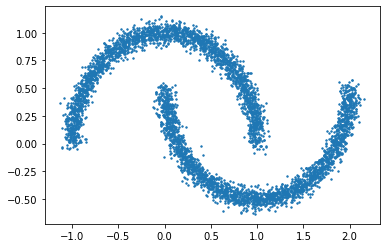

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)
        
    def __call__(self, z):
        return self.fc1(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
    
    def __call__(self, x):
        return self.fc1(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

In [ ]:
pip install utils

step 0: discriminator: 1.238e+00, generator: -5.835e-01


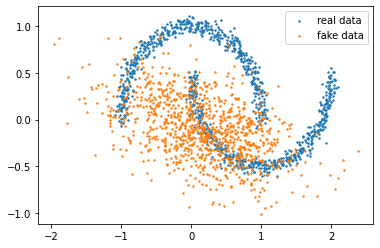

step 1000: discriminator: 2.135e-01, generator: -6.852e-01


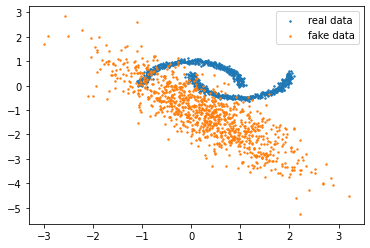

step 2000: discriminator: 3.406e-01, generator: -5.493e-01


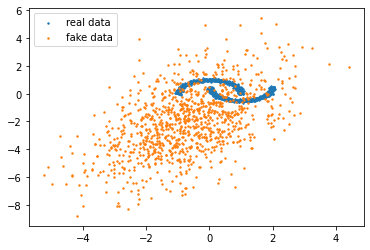

step 3000: discriminator: 3.910e-01, generator: -6.297e-01


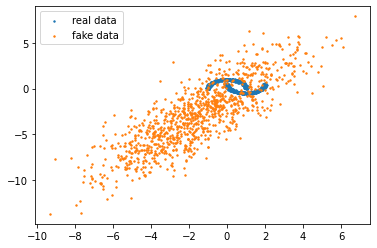

step 4000: discriminator: 3.120e-01, generator: -4.819e-01


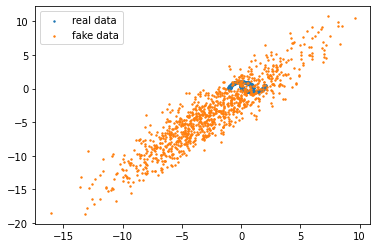

step 5000: discriminator: 3.397e-01, generator: -4.908e-01


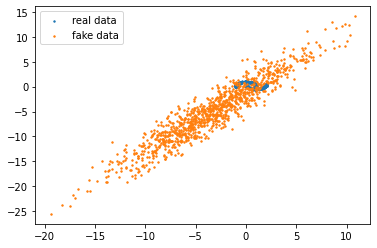

step 6000: discriminator: 3.437e-01, generator: -5.193e-01


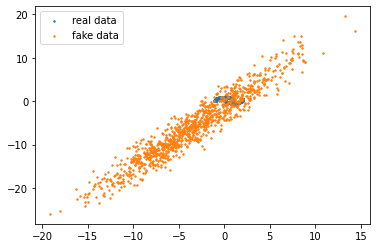

step 7000: discriminator: 4.043e-01, generator: -3.596e-01


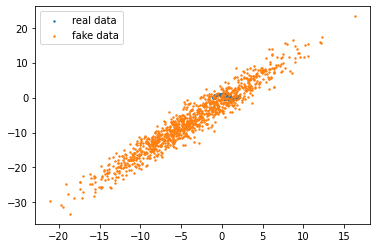

step 8000: discriminator: 3.420e-01, generator: -4.244e-01


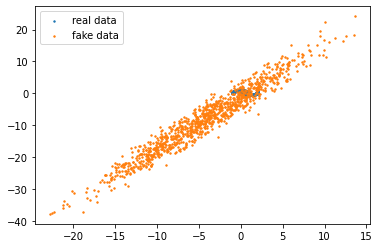

step 9000: discriminator: 3.663e-01, generator: -5.177e-01


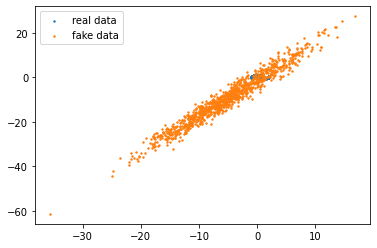

step 10000: discriminator: 3.331e-01, generator: -5.092e-01


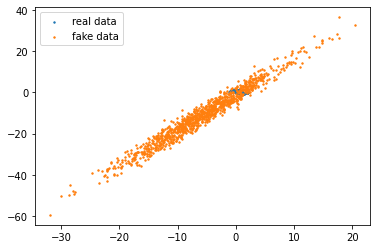

step 11000: discriminator: 3.842e-01, generator: -4.357e-01


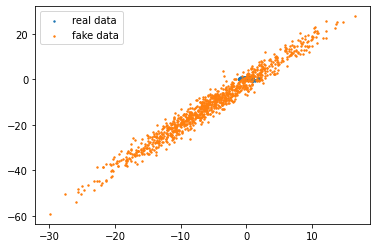

step 12000: discriminator: 3.698e-01, generator: -4.760e-01


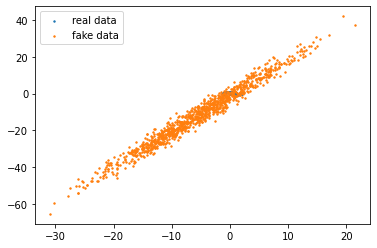

step 13000: discriminator: 3.739e-01, generator: -4.307e-01


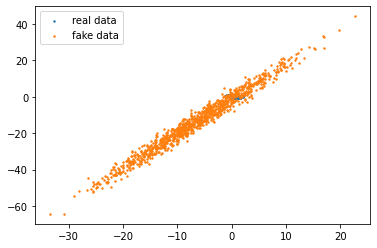

step 14000: discriminator: 3.916e-01, generator: -4.470e-01


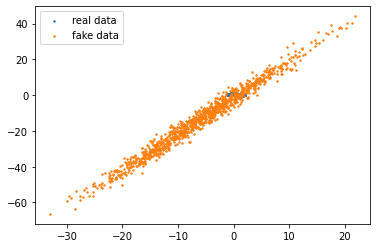

step 15000: discriminator: 3.617e-01, generator: -5.750e-01


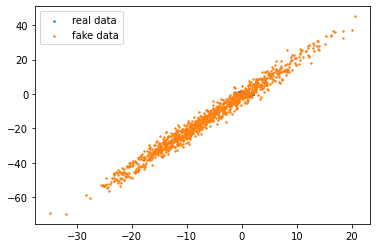

step 16000: discriminator: 3.659e-01, generator: -5.140e-01


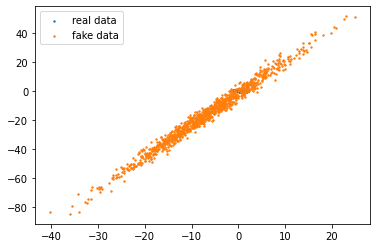

step 17000: discriminator: 3.970e-01, generator: -5.037e-01


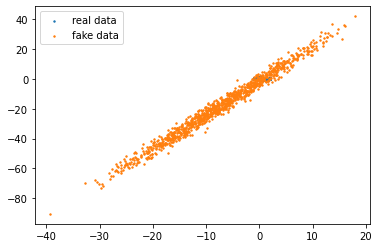

step 18000: discriminator: 3.781e-01, generator: -4.641e-01


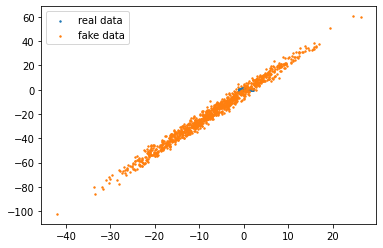

step 19000: discriminator: 3.472e-01, generator: -5.442e-01


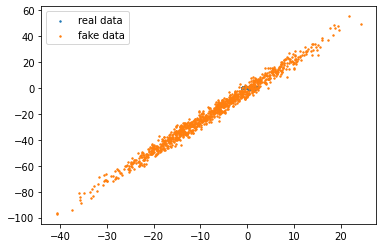

step 20000: discriminator: 3.731e-01, generator: -4.509e-01


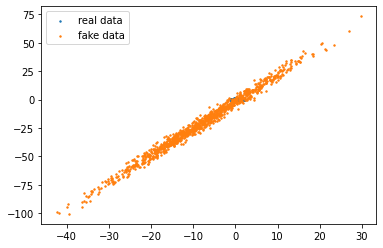

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))
#loss=nn.BCELoss()
loss=torch.nn.MSELoss()
from torch.autograd import Variable

real_y = Variable(torch.ones(BATCHLEN, 1))
fake_y = Variable(torch.zeros(BATCHLEN, 1))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        h_real=discriminator(real_batch)
        h_fake=discriminator(fake_batch)
        loss_real = loss(h_real,real_y)
        #loss_real.backward()
        loss_fake = loss(h_fake,fake_y)  
        #loss_fake.backward()      
        disc_loss = loss_real+loss_fake
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    h_fake = discriminator(fake_batch)
    gen_loss = - loss(h_fake,real_y)
    #
    #gen_loss = 0
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

GANs are composed by two networks, and each one of them has its loss function, results in the fact that GANs are inherently unstable- diving a bit deeper into the problem, the Generator (G) loss can lead to the GAN instability, which can be the cause of the gradient vanishing problem when the Discriminator (D) can easily distinguish between real and fake samples.In GANs architecture, the D tries to minimize a cross-entropy while the G tries to maximize it. When D confidence is high and starts to reject the samples that are produced by G leads to G’s gradient vanishes.

Also For the generator's loss , the gradient signal is dominated by regions where the generated sample is already good. However when the generated sample is fake, then the gradient in that region is flat.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

1)depth / width of the generator network: 
the generator with higher depth / width ratio migth not generate good data samples. And a generator with too low depth / width ratio will not learn to produce data that is a representation of the training data distribution.

2)depth / width of the discriminator network:
the discriminator with too high or too low depth / width ratio  will not converge, or unable to discriminate between real and fake samples generated by the generator.

3)impact of TRAIN_RATIO:
for too small train_ratio, the GANS training might not converage, on the other hand if the ratio is too high, it might produce deplicates

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

The KL divergence indicates us how close probability distribution ${p_\theta}$ is close to the probability ${p_D}$ by calculating the cross entropy minus the entropy.
<br/>
<br/>
$ D_{KL}(p_D \| p_\theta) = \int_{x\in X}{p_D(x)log(\frac{p_D(x)}{p_\theta(x)})}$ <br/>
$ = \int_{x\in X}{p_D(x)log({p_D(x))}} - \int_{x\in X}{p_D(x)log({p_\theta(x))}}$ <br/>
$ = \mathbb{E}_{p_D} log(p_D(x)) - \mathbb{E}_{p_D} log(p_\theta(x))$ <br/>
$ = \mathbb{E}_{p_D} (log(p_D(x)) - log(p_\theta(x)))$ <br/>
$ = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$ <br/>

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

$p(z)$ is not seen because it is difficult to calculate.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> We know that
 $D_{\phi_x} = Diag(\sigma_\phi(x))$  
$D_{KL}(q_\phi(z | x) \| p(z)) = \int q_{\phi}(z|x)log\left(\frac{q_{\phi}(z|x)}{p(z)}\right)dz$  
$= \int q_{\phi}(z|x)*log\left( \frac{1}{\sqrt{det(D_{\phi_x})}}*\exp\left(\frac{1}{2}z^{T}z-\frac{1}{2}(z-\mu_{\theta})^{T}D_{\phi_x}^{-1}(z-\mu_{\phi})\right)\right)dz$  
$= \int \left[ 
-\frac{1}{2}q_{\phi}(z|x)log\left( det(D_{\phi_x})\right) 
+ \frac{1}{2}q_{\phi}(z|x)z^{T}z 
- \frac{1}{2}q_{\phi}(z|x)(z-\mu_{\phi})^{T}D_{\phi_x}^{-1}(z-\mu_{\phi}) \right]dz$  
$= -\frac{1}{2}log\left( det(D_{\phi_x})\right) + \int \left[\frac{1}{2}q_{\phi}(z|x)z^{T}z - \frac{1}{2}q_{\phi}(z|x)(z-\mu_{\phi})^{T}D_{\phi_x}^{-1}(z-\mu_{\phi})\right]dz$  
$= -\frac{1}{2}log\left( det(D_{\phi_x})\right) + \frac{1}{2}E_{ q_{\phi}(z|x)}(z^{T}z) - \frac{n}{2}$  
$= -\frac{1}{2}log\left( det(D_{\phi_x})\right) + \frac{1}{2}\mu_{\phi}^{T}\mu_{\phi} + \frac{1}{2}tr(D_{\phi_x}) - \frac{n}{2}$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> With $D_{\theta_z} = Diag(\sigma_\theta(z))$  
$-\log p_\theta(x | z)$
$= \frac{1}{2}\log((2\pi)^{n}det(D_{\theta_z})) + \frac{1}{2}(x-\mu_{\theta}(z))^{T}D_{\theta_z}^{-1}(x-\mu_{\theta}(z))$
$=  \frac{n}{2}\log(2\pi) + \frac{1}{2}\sum_{i}\log(\sigma_{\theta,i}(z)) + \frac{1}{2}\sum_{i}{\sigma_{\theta,i}(z)}^{-1}(x_{i}-\mu_{\theta,i}(z))^{2}$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 5

LAYER_SIZE_ENC = 32
LAYER_SIZE_DEC = 32

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, LAYER_SIZE_ENC)
        self.fc2 = nn.Linear(LAYER_SIZE_ENC, LAYER_SIZE_ENC)
        self.fc3 = nn.Linear(LAYER_SIZE_ENC, LAYER_SIZE_ENC)
        self.fc_mu = nn.Linear(LAYER_SIZE_ENC, LATENT_N)
        self.fc_logvar = nn.Linear(LAYER_SIZE_ENC, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, LAYER_SIZE_DEC)
        self.fc2 = nn.Linear(LAYER_SIZE_DEC, LAYER_SIZE_DEC)
        self.fc3 = nn.Linear(LAYER_SIZE_DEC, LAYER_SIZE_DEC)
        self.fc_mu = nn.Linear(LAYER_SIZE_DEC, 2)
        self.fc_logvar = nn.Linear(LAYER_SIZE_DEC, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 6.414e+00, rec: 7.274e-01


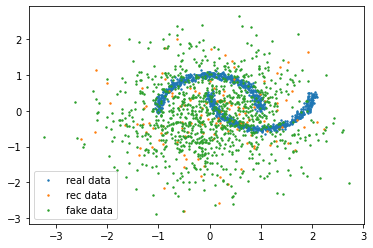

step 1000: KL: 3.088e-04, rec: 7.350e-01


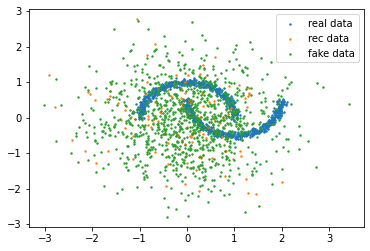

step 2000: KL: 2.283e-04, rec: 7.209e-01


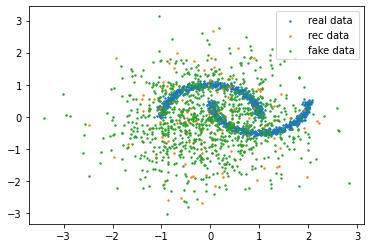

step 3000: KL: 1.318e-04, rec: 7.727e-01


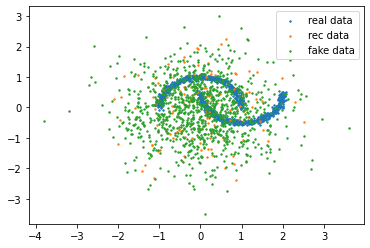

step 4000: KL: 2.047e-04, rec: 7.902e-01


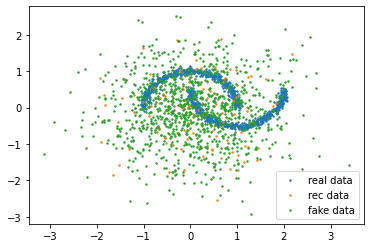

step 5000: KL: 1.866e-04, rec: 8.367e-01


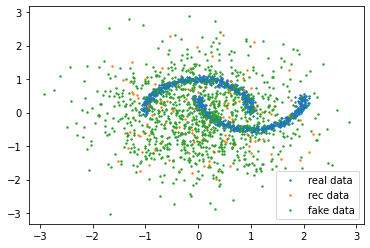

step 6000: KL: 2.349e-04, rec: 7.697e-01


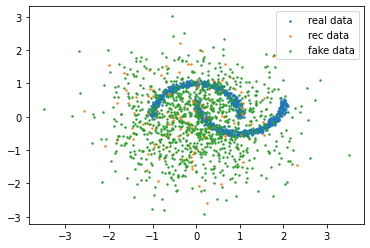

step 7000: KL: 1.113e-04, rec: 7.667e-01


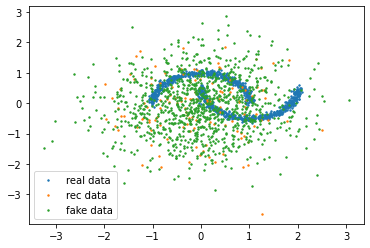

step 8000: KL: 2.451e-04, rec: 8.298e-01


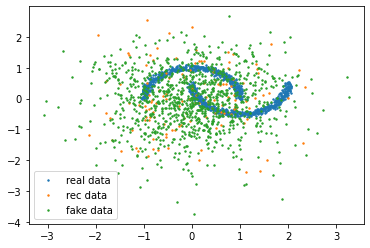

step 9000: KL: 2.113e-05, rec: 7.984e-01


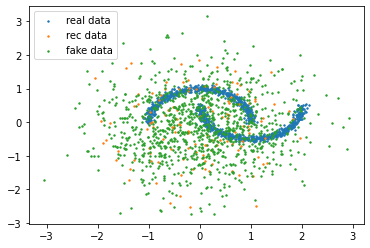

step 10000: KL: 1.278e-04, rec: 7.657e-01


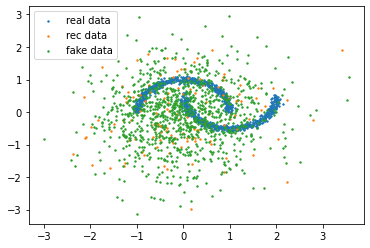

step 11000: KL: 2.730e-04, rec: 8.562e-01


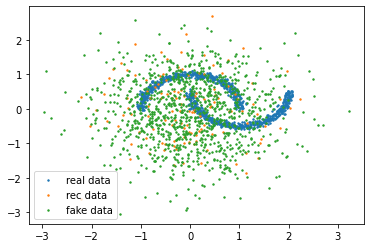

step 12000: KL: 2.807e-04, rec: 8.406e-01


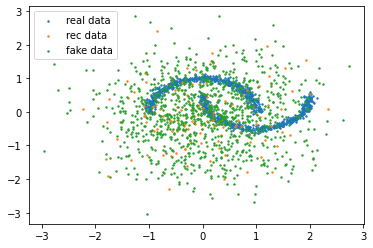

step 13000: KL: 1.335e-05, rec: 7.349e-01


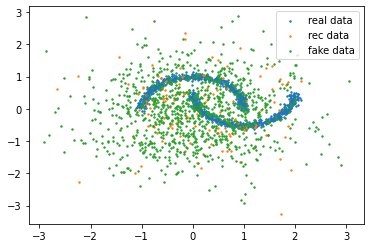

step 14000: KL: 1.311e-06, rec: 7.816e-01


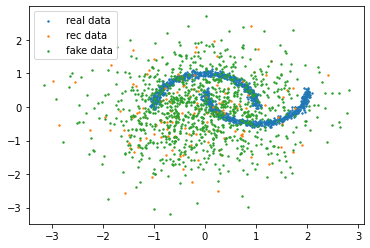

step 15000: KL: 3.341e-05, rec: 7.106e-01


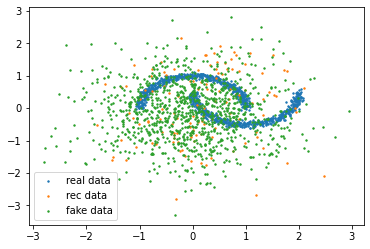

step 16000: KL: 2.503e-06, rec: 8.333e-01


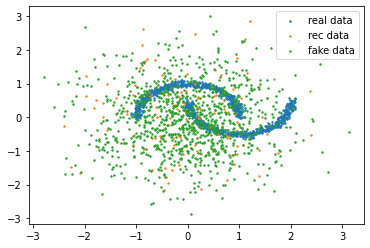

step 17000: KL: 1.526e-05, rec: 8.272e-01


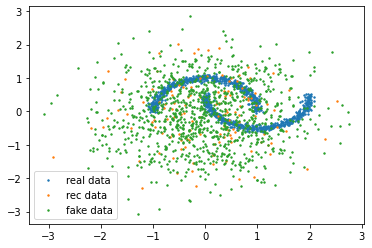

step 18000: KL: 2.670e-05, rec: 7.513e-01


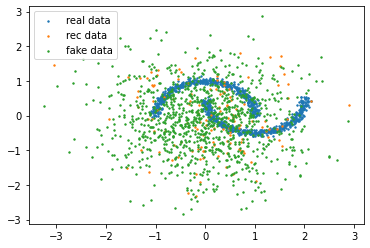

step 19000: KL: 7.629e-06, rec: 7.630e-01


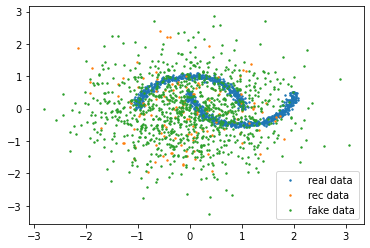

step 20000: KL: 8.774e-05, rec: 7.640e-01


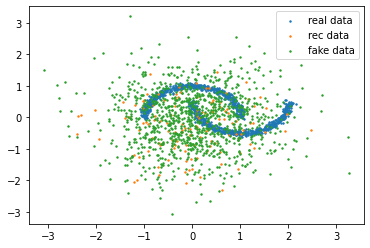

step 21000: KL: 7.629e-06, rec: 7.700e-01


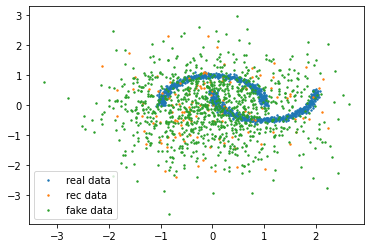

step 22000: KL: 1.144e-05, rec: 8.658e-01


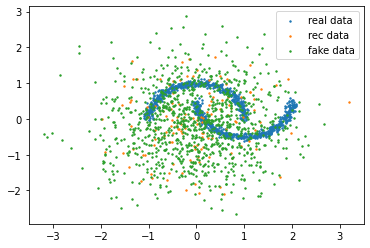

step 23000: KL: 4.959e-05, rec: 8.523e-01


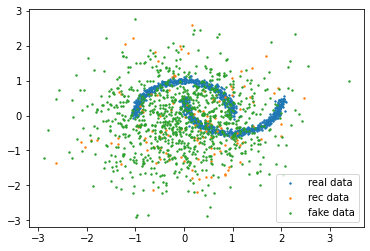

step 24000: KL: 3.433e-05, rec: 8.036e-01


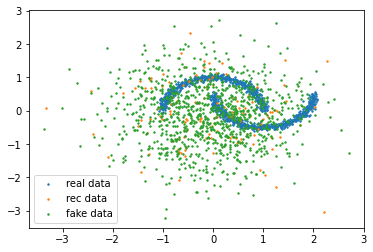

step 25000: KL: 2.295e-05, rec: 7.741e-01


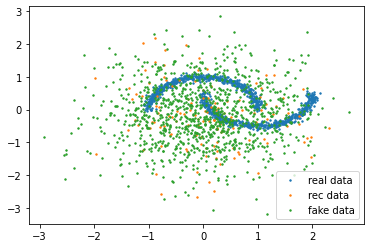

step 26000: KL: 3.052e-05, rec: 8.157e-01


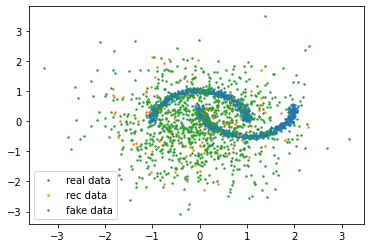

step 27000: KL: 2.670e-05, rec: 7.883e-01


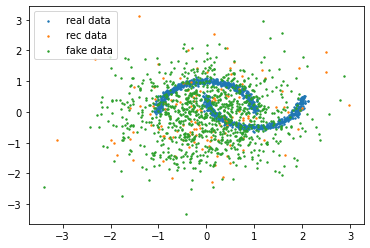

step 28000: KL: 1.526e-05, rec: 7.683e-01


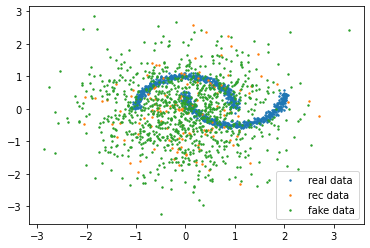

step 29000: KL: 3.815e-05, rec: 7.716e-01


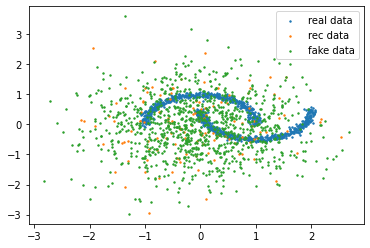

step 30000: KL: 3.433e-05, rec: 8.391e-01


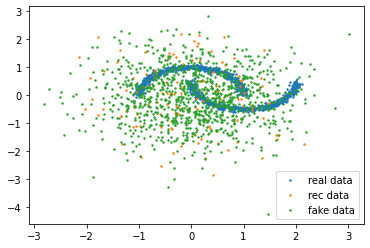

step 31000: KL: -0.000e+00, rec: 8.728e-01


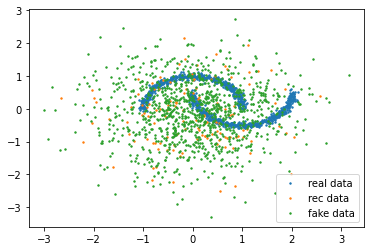

step 32000: KL: 1.526e-05, rec: 7.049e-01


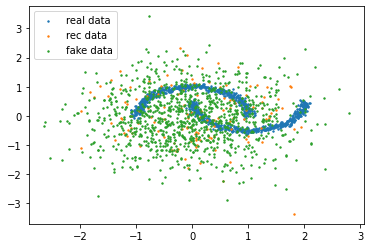

step 33000: KL: 1.144e-04, rec: 8.411e-01


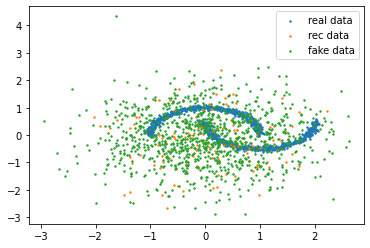

step 34000: KL: 3.052e-05, rec: 7.680e-01


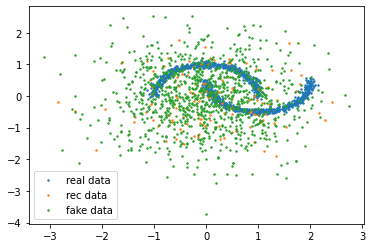

step 35000: KL: -0.000e+00, rec: 7.350e-01


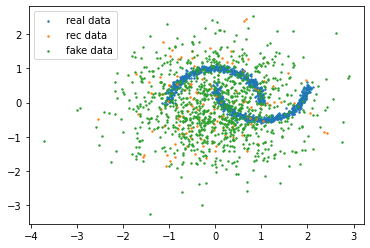

step 36000: KL: 4.196e-05, rec: 7.840e-01


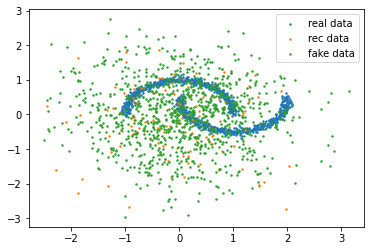

step 37000: KL: -0.000e+00, rec: 7.227e-01


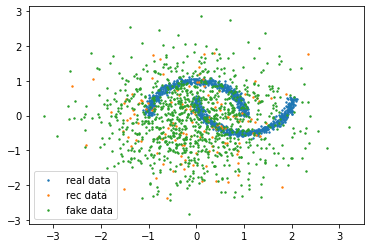

step 38000: KL: -0.000e+00, rec: 8.043e-01


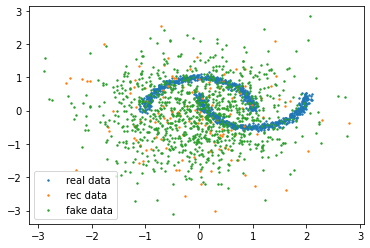

step 39000: KL: 3.815e-06, rec: 8.032e-01


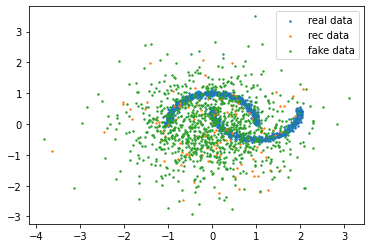

step 40000: KL: -0.000e+00, rec: 8.251e-01


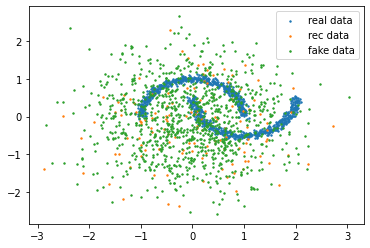

In [ ]:
dtype = torch.FloatTensor

# Reparameterization Trick

def reparameterize_trick(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

def compute_bce_loss(input_, target):
    """
    Computes binary cross-entropy loss function.
    """
    neg_abs = - input_.abs()
    loss = input_.clamp(min=0) - input_ * target + (1 + neg_abs.exp()).log()
    return loss.mean()

# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = -0.5 * torch.sum(1 + enc_logvar - enc_mu.pow(2) - enc_logvar.exp())
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    z = reparameterize_trick(enc_mu,enc_logvar)
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    recon_x = torch.normal(dec_mu, torch.exp(0.5*dec_logvar))
    
    loss_rec = compute_bce_loss(recon_x, x)
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

VAE work on two important principles. On the one hand, the encoder network tries to make the posterior distribution close to the prior. On the other hand, the decoder network tries to maximise the probability that the original input is reconstructed. 
However, if 𝜎𝜃(𝑧) is fixed and only 𝜇𝜃(𝑧) is learned, the decoder is hindered, so its goal of making the probabilities of the original input and its reconstruction close has no effect. Thus, although general learning will take less time, the generated samples will be noisy and not very usable.

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**



>Impact of the width/depth of the decoder network

The decoder network aims to maximise the probability that the original input is reconstructed. Too high or too low a decoder network capacity will produce very noisy data and the learning will not converge.
    
>Impact of Latent_N

The different choices of dimension of LATENT_N encode interpretable variation factors in the generated data. However, a value of LATENT_N that is too large or too small may cause the training to diverge.

>Impact of the width/depth of the encoding network

The main objective of the encoding network is to approximate the posterior distribution to the prior distribution and we observe that too high or too low a capacity of the encoding network will not be able to achieve this objective and the learning will diverge.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> Answer:

We begin from the identity and taking the negative gradient so that:
$$
\log(p_X(x))=\log(p_Z(z))-\log \det J_f
$$

After that, we group the logarithms:
$$
\log(p_X(x))=\log(p_Z(z)/det J_f)
$$

Then, we remove the logs from both sides of the equalities:
$$
p_X(x)=p_Z(z)/det J_f
$$

Next, the equality is reordered 
$$
p_Z(z)=p_X(x) det J_f
$$

From the formula that we will demonstrate, we begin with:
$$
 \int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz
$$

And we replace it having:
$$
 \int_{z\sim p_\mathcal{G}} g(f^{-1}(z)) dz = \int_{x\sim p_\mathcal{N}} g(p_X(x) det J_f) dx 
$$

The jacobian function then is:
$$
\int_{x\sim p_\mathcal{G}} g(p_X(x) det \frac{df(x)}{dx}) dx
$$

Which is further simplified to:
$$
\int_{z\sim p_\mathcal{G}} g(p_X(x)) dx
$$

And finally this corresponds to:
$$
\int_{x\sim p_\mathcal{G}} g(x) dx
$$

Which satisfies the equality:
$$
\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx
$$

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

A very simple loss function of the KL divergence will be:

$$
\sum_i p(x_i) log\frac{P_D(X_i)}{P_G(X_i)}
$$


A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> Answer:

From the mapping we can see that:

The first part is indeed invertible having:
$$
x_{1:d} = y_{1:d}
$$

For the second one we have:
$$
x_{d+1:D} = (y_{d+1:D} - t(y_{1:d}))  \odot \exp(-s(y_{1:d}))
$$

There is no need to invert the functions s and t because the inverted function shows that we need to substract this same functions.

Also, by sampling it can be found that both of them are bijective.

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> Answer

The jacobian matrix has the form:

$$
\frac{∂y}{∂x^T} = diag(\exp s(x_{1:d}))
$$

For all the values such that $ ∂y_{d+1:D}/∂x_{1:d} $.
Otherwise, it has the form:

$$
\frac{∂y}{∂x^T} = 0
$$

To calculate the determinant we have that the general formula is:
$$
det(A) = \sum_j o(j) a_1 a_2 ... a_n
$$

For this specific matrix as we are calculating based on diagonals, the related formula will be:
$$
det(\frac{∂y}{∂x^T}) = \sum_j \exp s(x_{1:d})
$$

No other values will be calculated because appart from the diagonals, eveything else is 0. By applying the sum of exponentials equals the exponential of the sum we get:

$$
det(\frac{∂y}{∂x^T}) = \exp( \sum_j s(x_{1:d}))
$$

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
      super().__init__()
      ### define here variables to use in f and s ###
      self.input_size = input_size
      self.output_size = output_size
      self.hidden_size = hidden_size

      self.l1 = nn.Sequential(nn.Linear(self.input_size, self.hidden_size), nn.LeakyReLU(),
                                nn.Linear(self.hidden_size, self.hidden_size), nn.LeakyReLU(),
                                nn.Linear(self.hidden_size, self.output_size), nn.Tanh())
      
      self.l2 = nn.Sequential(nn.Linear(self.input_size, self.hidden_size), nn.LeakyReLU(),
                          nn.Linear(self.hidden_size, self.hidden_size), nn.LeakyReLU(),
                          nn.Linear(self.hidden_size, self.output_size), nn.Tanh())

      ###
      self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
      return self.l1(x_m)
        
    def tfun(self, x_m):
      return self.l2(x_m)
        
    def forward(self, x):
      x_m = x * self.mask
      s_out = self.sfun(x_m) # multiplicative block
      t_out = self.tfun(x_m) # additive block
      y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
      log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
      return y, log_det_jacobian

    def inverse(self, y):
      y_m = y * self.mask
      s_out = self.sfun(y_m) 
      t_out = self.tfun(y_m) 
      x = y_m + (1-self.mask)*(y * torch.exp(-s_out) - t_out)
      return x

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.021735
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.039706
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.048940
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.051867
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.053946
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.054742
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.054768
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.055555
====> Epoch: 1 Average train loss: -0.0480


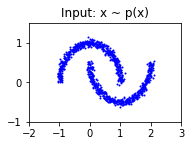

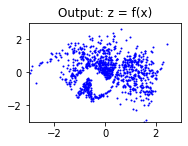

====> Test loss: -0.0575


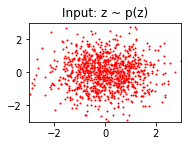

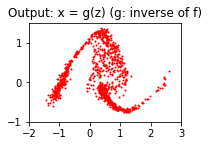

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.056445
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.057594
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.056053
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.056326
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.057648
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.058390
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.057660
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.057804
====> Epoch: 2 Average train loss: -0.0572


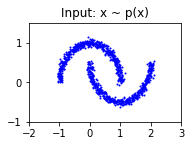

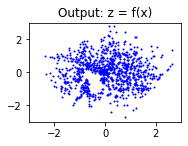

====> Test loss: -0.0595


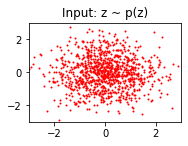

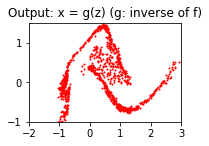

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.057692
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.057735
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.057634
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.058895
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.058050
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.059114
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.058942
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.058459
====> Epoch: 3 Average train loss: -0.0582


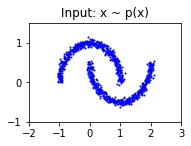

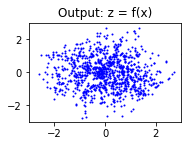

====> Test loss: -0.0605


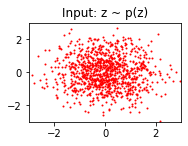

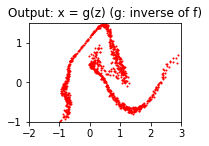

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.058918
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.059138
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.058999
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.059064
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.059496
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.058029
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.059646
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.059226
====> Epoch: 4 Average train loss: -0.0590


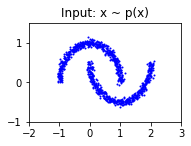

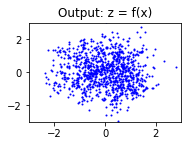

====> Test loss: -0.0607


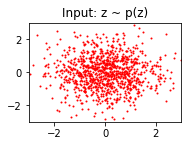

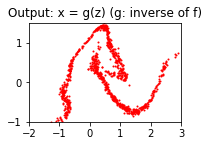

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.059449
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.059344
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.059157
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.058262
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.059481
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.057833
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.058926
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.059190
====> Epoch: 5 Average train loss: -0.0593


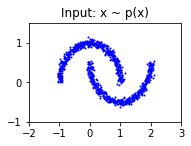

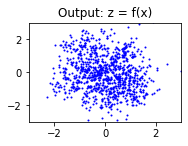

====> Test loss: -0.0604


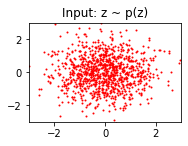

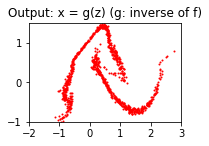

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.059455
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.058934
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.057319
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.059609
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.059666
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.059759
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.058903
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.059494
====> Epoch: 6 Average train loss: -0.0593


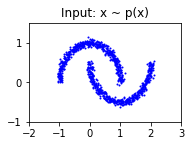

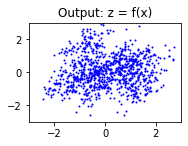

====> Test loss: -0.0601


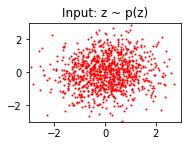

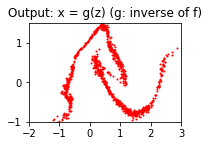

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.058484
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.058490
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.060233
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.059172
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.059137
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.059431
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.059559
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.060050
====> Epoch: 7 Average train loss: -0.0594


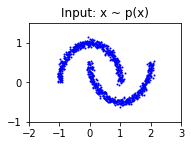

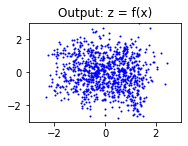

====> Test loss: -0.0607


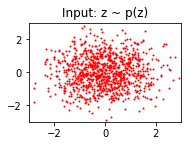

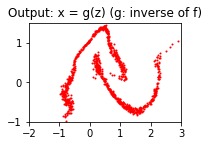

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.058938
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.059173
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.059574
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.060046
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.059995
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.059135
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.059304
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.059211
====> Epoch: 8 Average train loss: -0.0594


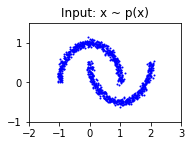

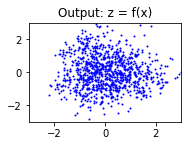

====> Test loss: -0.0608


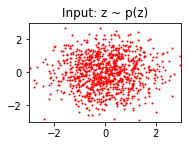

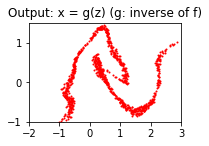

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.058577
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.059445
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.059091
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.060236
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.059783
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.059514
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.059463
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.059959
====> Epoch: 9 Average train loss: -0.0595


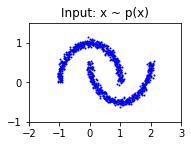

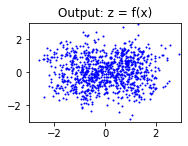

====> Test loss: -0.0608


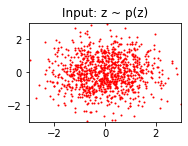

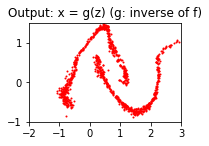

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.060100
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.059379
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.059363
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.059356
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.059509
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.060451
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.059696
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.059249
====> Epoch: 10 Average train loss: -0.0596


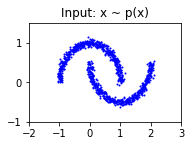

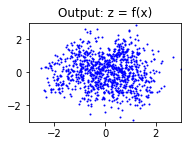

====> Test loss: -0.0609


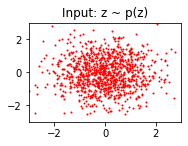

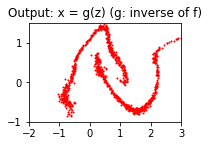

'185.54s'

<Figure size 432x288 with 0 Axes>

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

The Normalizing flows are very good at generation tasks for distributions where the exact likelihood of a data point should be easily computable. When the data is clustered, then it is most common that the function mapping wont be simple, in some cases not invertible and therefore, the normalizing flows will not be an appropriate modelling for this generative task. It would be better to use either GANs or VAE.

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**


As we can see from the GAN part of the exercise, the advantage of GANS is it is go into details of data and can easily interpret into different versions and generate data that looks similar to original data without explicit model density function.

the problem with GANS is that it is hard to train, different types of data need to provided to see if if it works accurately or not.

For the VAE part of this assignment, what we can say is that as they are made for arbitrary computational graphs, they are applicable to a wide range of models because there is no need to restrict the choice of models.
Moreover, In other words, VAEs allow inference of $q(z|x)$ which can be a useful feature representation for other tasks. This makes it an excellent manifold learning algorithm.

As drawbacks, we can say that VAEs lead to lower quality images compared to GANs (the images are blurrier). And, they learn an inference network for only one problem, inferring z given x.

As reviewed in the exercise, the main advantage of Normalizing flows is its capacity of generating a normal distribution from the input data than can be mapped to generate similar data points.

There are certain constraints for it to work well:

- First network configuration with Coupling layers that have the same size so that it is possible to compute the Jacobians and optimize the problem.
- Also the network should be invertible, meaning that the mapping of the function can be done without much difficulties or complex calculations.
- It is also preferable that the input data is not a clustered data.

If these conditions are met the optimization problem may converge, thus Normalizing flows will be a good approximation to solve this generative problem. If this is not the case, the network will not optimize correctly, may not converge and another generative solution should be attempted.